In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rc("font", size=20)

In [3]:
cuda = True
device = torch.device("cuda:0" if cuda and torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
class MLP(torch.nn.Module):
    def __init__(self, ninput, nhidden, nout, bn=False, do=False):
        super(MLP, self).__init__()
        layers = []
        layers.append(torch.nn.Linear(ninput, nhidden))
        layers.append(torch.nn.BatchNorm1d(nhidden)) if bn else 0
        layers.append(torch.nn.Dropout(0.5)) if do else 0
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(nhidden, nout))
        self.mlp = torch.nn.Sequential(*layers)


    def forward(self, x):
        return self.mlp(x)
    
    
class AE(torch.nn.Module):
    def __init__(self, nin, nl, nh):
        super(AE, self).__init__()
        self.enc1 = torch.nn.Linear(nin, nh)
        self.enc2 = torch.nn.Linear(nh, nl)
        self.dec1 = torch.nn.Linear(nh, nin)
        self.dec2 = torch.nn.Linear(nl, nh)
        self.relu = torch.nn.ReLU()
        self.sig = torch.nn.Sigmoid()
        self.bne1 = torch.nn.BatchNorm1d(nh)
        self.bnd1 = torch.nn.BatchNorm1d(nh)
    
    def encode(self, x):
        e1 = self.relu(self.bne1(self.enc1(x)))
        return self.enc2(e1)
    
    def decode(self, u):
        d1 = self.relu(self.bnd1(self.dec2(u)))
        return self.sig(self.dec1(d1))
        
    def forward(self, x):
        l = self.encode(x)
        r = self.decode(l)
        return l, r

In [26]:
lr = 2e-4
wd = 0.
bs = 100
neurons = 1000
nh = 500
ld = 100
epochs = 20

In [27]:
transform = [torchvision.transforms.ToTensor()]

N = None

trainset = torchvision.datasets.MNIST(root="datasets/mnist/train", train=True, download=True, transform=torchvision.transforms.Compose(transform))
testset = torchvision.datasets.MNIST(root="datasets/mnist/test", train=False, download=True, transform=torchvision.transforms.Compose(transform))
if N != None:
    train_tensor = torch.tensor(trainset.data)[:N].float().to(device).reshape(N, -1)/255.
    test_tensor = torch.tensor(testset.data)[:N].float().to(device).reshape(N, -1)/255.
    trainDataset = torch.utils.data.TensorDataset(train_tensor, trainset.targets[:N].to(device))
    testDataset = torch.utils.data.TensorDataset(test_tensor, testset.targets[:N].to(device))
else:
    train_tensor = torch.tensor(trainset.data).float().to(device).reshape((trainset.data.shape[0], trainset.data.shape[1]**2))/255.
    test_tensor = torch.tensor(testset.data).float().to(device).reshape((testset.data.shape[0], testset.data.shape[1]**2))/255.
    trainDataset = torch.utils.data.TensorDataset(train_tensor, trainset.targets.to(device))
    testDataset = torch.utils.data.TensorDataset(test_tensor, testset.targets.to(device))


trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=bs, shuffle=True)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=bs, shuffle=True)

/home/mromero/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/home/mromero/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [28]:
cel = torch.nn.CrossEntropyLoss().to(device)
bcel = torch.nn.BCELoss().to(device)
msel = torch.nn.MSELoss().to(device)

In [29]:
def train_my_model(epochs, model, optimizer, loss_function, trainloader, valloader, testloader):
    losses = np.zeros((epochs, 3))
    best_val_loss = np.inf
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        test_loss = 0
        model.train()
        for i, batch in enumerate(trainloader):
            x_in, y_in = batch
            _, x_out = model(x_in)
            loss = loss_function(x_out, x_in)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= i + 1
        model.eval()
        with torch.no_grad():
            if valloader != None:
                for i, batch in enumerate(valloader):
                    x_in, y_in = batch
                    _, x_out = model(x_in)
                    loss = loss_function(x_out, x_in)
                    val_loss += loss.item()
                val_loss /= i + 1
            for i, batch in enumerate(testloader):
                x_in, y_in = batch
                _, x_out = model(x_in)
                loss = loss_function(x_out, x_in)
                test_loss += loss.item()
            test_loss /= i + 1
        losses[epoch] = [train_loss, val_loss, test_loss]
        print("Epoch {} Train loss {:.3f} Val loss {:.3f} Test loss {:.3f}".format(epoch, train_loss, val_loss, test_loss))
        if valloader != None:
            if val_loss < best_val_loss:
                print("Saving")
                torch.save(model.state_dict(), "models/ae.pth")
                best_val_loss = val_loss
        else:
            if test_loss < best_val_loss:
                print("Saving")
                torch.save(model.state_dict(), "models/ae.pth")
                best_val_loss = test_loss
    return losses


def plot_my_loss(loss, title, ylabel="mean cross entropy"):
    plt.figure(figsize=(20, 5))
    plt.plot(loss[:, 0], color="navy", label="train")
    plt.plot(loss[:, 1], color="green", label="val")
    plt.plot(loss[:, 2], color="red", label="test")
    plt.xlabel("epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.ylim([0, 2])
    return


def eval_my_model(model, test_data):
    model.eval()
    with torch.no_grad():
        xl, x_out = model(test_data)
    return xl.cpu().numpy(), x_out.cpu().numpy()

In [30]:
model_bce = AE(train_tensor.shape[1], ld, nh)
if torch.cuda.device_count() > 1:
  print("# gpus: {}".format(torch.cuda.device_count()))
  model_bce = torch.nn.DataParallel(model_bce)
model_bce.to(device)

optimizer_bce = torch.optim.Adamax(model_bce.parameters(), lr=lr, weight_decay=wd)
loss_bce = train_my_model(epochs, model_bce, optimizer_bce, bcel, trainLoader, None, testLoader)
model_bce.load_state_dict(torch.load("models/ae.pth"))

# gpus: 4
Epoch 0 Train loss 0.264 Val loss 0.000 Test loss 0.196
Saving
Epoch 1 Train loss 0.195 Val loss 0.000 Test loss 0.174
Saving
Epoch 2 Train loss 0.179 Val loss 0.000 Test loss 0.160
Saving
Epoch 3 Train loss 0.165 Val loss 0.000 Test loss 0.150
Saving
Epoch 4 Train loss 0.156 Val loss 0.000 Test loss 0.145
Saving
Epoch 5 Train loss 0.153 Val loss 0.000 Test loss 0.141
Saving
Epoch 6 Train loss 0.150 Val loss 0.000 Test loss 0.139
Saving
Epoch 7 Train loss 0.147 Val loss 0.000 Test loss 0.136
Saving
Epoch 8 Train loss 0.145 Val loss 0.000 Test loss 0.134
Saving
Epoch 9 Train loss 0.143 Val loss 0.000 Test loss 0.133
Saving
Epoch 10 Train loss 0.142 Val loss 0.000 Test loss 0.131
Saving
Epoch 11 Train loss 0.141 Val loss 0.000 Test loss 0.130
Saving
Epoch 12 Train loss 0.141 Val loss 0.000 Test loss 0.131
Epoch 13 Train loss 0.140 Val loss 0.000 Test loss 0.130
Saving
Epoch 14 Train loss 0.140 Val loss 0.000 Test loss 0.130
Epoch 15 Train loss 0.140 Val loss 0.000 Test loss 0.1

In [31]:
model_mse = AE(train_tensor.shape[1], ld, nh)
if torch.cuda.device_count() > 1:
  print("# gpus: {}".format(torch.cuda.device_count()))
  model_mse = torch.nn.DataParallel(model_mse)
model_mse.to(device)


optimizer_mse = torch.optim.Adamax(model_mse.parameters(), lr=lr, weight_decay=wd)
loss_mse = train_my_model(epochs, model_mse, optimizer_mse, msel, trainLoader, None, testLoader)
model_mse.load_state_dict(torch.load("models/ae.pth"))

# gpus: 4
Epoch 0 Train loss 0.061 Val loss 0.000 Test loss 0.039
Saving
Epoch 1 Train loss 0.040 Val loss 0.000 Test loss 0.036
Saving
Epoch 2 Train loss 0.038 Val loss 0.000 Test loss 0.034
Saving
Epoch 3 Train loss 0.036 Val loss 0.000 Test loss 0.032
Saving
Epoch 4 Train loss 0.034 Val loss 0.000 Test loss 0.030
Saving
Epoch 5 Train loss 0.033 Val loss 0.000 Test loss 0.028
Saving
Epoch 6 Train loss 0.031 Val loss 0.000 Test loss 0.027
Saving
Epoch 7 Train loss 0.030 Val loss 0.000 Test loss 0.026
Saving
Epoch 8 Train loss 0.029 Val loss 0.000 Test loss 0.025
Saving
Epoch 9 Train loss 0.028 Val loss 0.000 Test loss 0.025
Saving
Epoch 10 Train loss 0.028 Val loss 0.000 Test loss 0.024
Saving
Epoch 11 Train loss 0.027 Val loss 0.000 Test loss 0.024
Saving
Epoch 12 Train loss 0.027 Val loss 0.000 Test loss 0.023
Saving
Epoch 13 Train loss 0.026 Val loss 0.000 Test loss 0.023
Saving
Epoch 14 Train loss 0.026 Val loss 0.000 Test loss 0.023
Epoch 15 Train loss 0.026 Val loss 0.000 Test l

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

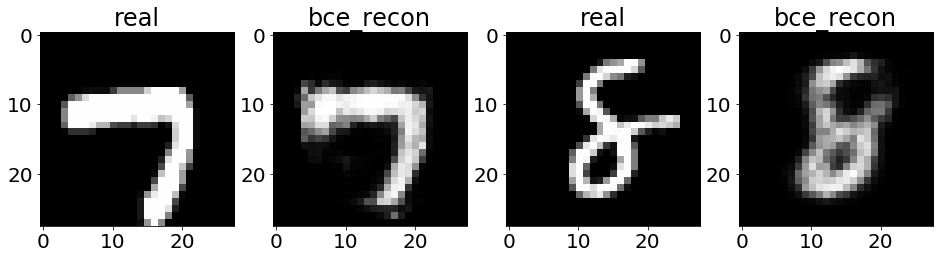

<Figure size 432x288 with 0 Axes>

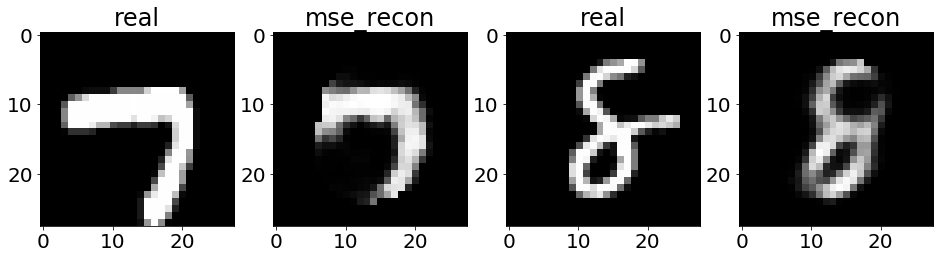

In [32]:
n = 2
idx = np.random.choice(np.arange(0, test_tensor.shape[0]), size=n, replace=False)
xl_bce, x_out_bce = eval_my_model(model_bce, test_tensor[idx])
xl_mse, x_out_mse = eval_my_model(model_mse, test_tensor[idx])

plt.gray()
plt.figure()
rs = 28
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(4*4, 4))
ax[0].set_title("real")
ax[0].imshow(test_tensor[idx[0]].cpu().numpy().reshape((rs, rs)))
ax[1].set_title("bce_recon")
ax[1].imshow(x_out_bce[0].reshape((rs, rs)))
ax[2].set_title("real")
ax[2].imshow(test_tensor[idx[1]].cpu().numpy().reshape((rs,rs)))
ax[3].set_title("bce_recon")
ax[3].imshow(x_out_bce[1].reshape((rs, rs)))
plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(4*4, 4))
ax[0].set_title("real")
ax[0].imshow(test_tensor[idx[0]].cpu().numpy().reshape((rs, rs)))
ax[1].set_title("mse_recon")
ax[1].imshow(x_out_mse[0].reshape((rs, rs)))
ax[2].set_title("real")
ax[2].imshow(test_tensor[idx[1]].cpu().numpy().reshape((rs, rs)))
ax[3].set_title("mse_recon")
ax[3].imshow(x_out_mse[1].reshape((rs, rs)))